In [1]:
#Packages import
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import math
import astropy.units as u

Note: Comments in this notebook are written just after the number sign #, which helps distinguish the real code from the comments. You can delete them if you want.

In [2]:
# Search for your target using its TIC ID 
TIC = 'TIC 239332587' 

In [3]:
# Check the availability of the data for this target
available_data_all = lk.search_lightcurve(TIC, mission = 'TESS')

In [4]:
available_data_all

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 15,2019,TESS-SPOC,1800,239332587,0.0
1,TESS Sector 15,2019,QLP,1800,239332587,0.0
2,TESS Sector 41,2021,SPOC,120,239332587,0.0


In [5]:
# Select multiple sectors based on the available data above.
select_sectors = available_data_all[2]

In [6]:
# Download and illustrate multiple sectors.
collect_lc = select_sectors.download_all()

<IPython.core.display.Javascript object>


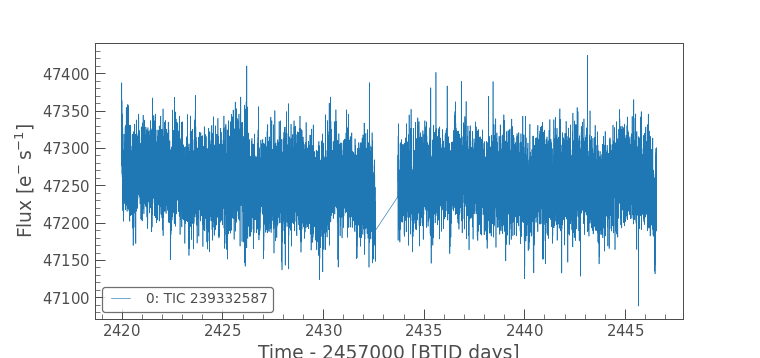

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

In [7]:
collect_lc.plot()

In [8]:
# Stitch the different sectors together, this '.stitch()' function also normalized the data for us
collect_lc = collect_lc.stitch()

<IPython.core.display.Javascript object>


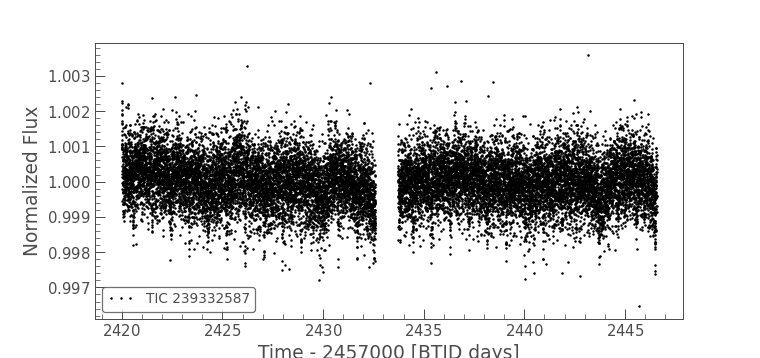

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

In [9]:
collect_lc.plot(color = 'black', lw = 0, marker = '.')

<IPython.core.display.Javascript object>


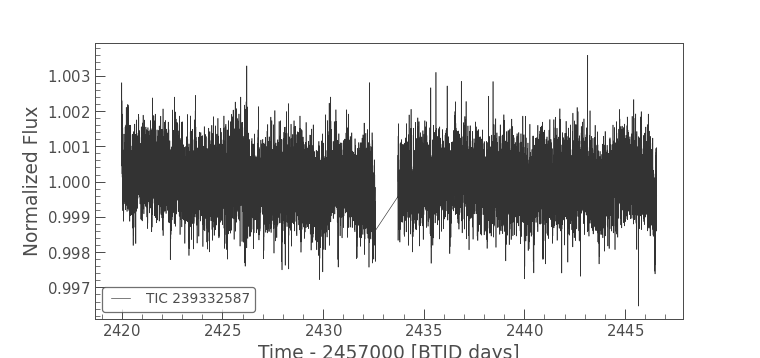

<IPython.core.display.Javascript object>


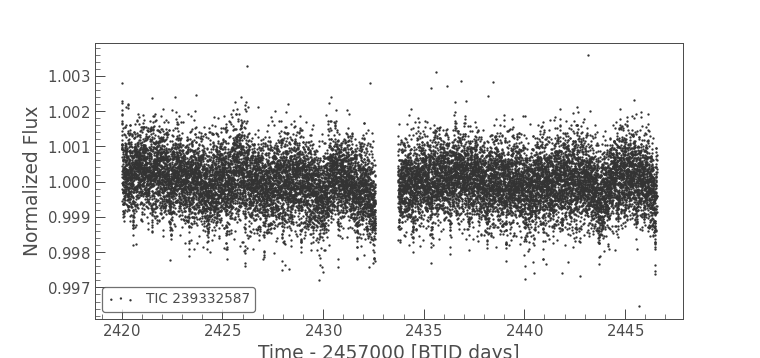

time,flux,flux_err,time_bin_start,time_bin_size,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,Time,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2420.0025882120262,1.0014930963516235,0.00014987505661944548,2419.9921715453597,0.020833333333333332,0.0024834757205098867,858632,193.36421498884312,42.87281698159538,43617.58984375,24.936342239379883,4717.50341796875,8.551438331604004,47325.5390625,27.429792404174805,0,nan,nan,nan,nan,193.36421498884312,0.0004417193413246423,42.87281698159538,0.0004464994417503476,0.006474797613918781,-0.05620410293340683
2420.0234215453597,1.000685453414917,0.0001552176129605089,2420.013004878693,0.020833333333333332,0.002484014257788658,858647,193.36531480879466,42.87247160757663,43594.1953125,24.949554443359375,4759.56982421875,8.578763008117676,47287.375,27.444326400756836,0,nan,nan,nan,nan,193.36531480879466,0.00044221297139301896,42.87247160757663,0.0004470913263503462,0.007633780594915152,-0.05697613209486008
2420.044254878693,1.0002621412277222,0.00015008213619391124,2420.0338382120262,0.020833333333333332,0.002484551863744855,858662,193.36558892146712,42.87233415254299,43589.36328125,24.970802307128906,4807.51416015625,8.61337947845459,47267.3671875,27.467693328857422,0,nan,nan,nan,nan,193.36558892146712,0.0004426364612299949,42.87233415254299,0.00044763239566236734,0.007774606812745333,-0.0572822280228138
2420.0650882120262,0.9999616742134094,0.00015021557919681072,2420.0546715453597,0.020833333333333332,0.0024850887712091208,858677,193.3652580646931,42.872881479277005,43589.26953125,24.992998123168945,4852.61767578125,8.646780967712402,47253.16796875,27.492115020751953,0,nan,nan,nan,nan,193.3652580646931,0.00044307560892775655,42.872881479277005,0.0004479859780985862,0.00783738773316145,-0.05639426037669182
2420.0859215453597,0.9997168183326721,0.0001503323515256246,2420.075504878693,0.020833333333333332,0.002485624747350812,858692,193.36515607583175,42.87188461980769,43584.44140625,25.012426376342773,4895.99267578125,8.676387786865234,47241.6015625,27.513484954833984,0,nan,nan,nan,nan,193.36515607583175,0.000443376658950001,42.87188461980769,0.0004483285010792315,0.0073681604117155075,-0.05742950364947319
2420.106754878693,0.9999873638153076,0.00015044407919049264,2420.0963382120262,0.020833333333333332,0.002486159559339285,858707,193.36568909570528,42.872398135664554,43594.40234375,25.03101921081543,4931.6875,8.702845573425293,47254.390625,27.533933639526367,0,nan,nan,nan,nan,193.36568909570528,0.0004436200833879411,42.872398135664554,0.0004485965764615685,0.00789062399417162,-0.05691967159509659
2420.1275882120262,1.00001060962677,0.00015048150283594925,2420.1171715453597,0.020833333333333332,0.002486694138497114,858722,193.36555269574393,42.87117154756337,43589.71484375,25.037248611450195,4947.654296875,8.713658332824707,47255.484375,27.540782928466797,0,nan,nan,nan,nan,193.36555269574393,0.00044383786735124886,42.87117154756337,0.0004486901452764869,0.00767852459102869,-0.05811019614338875
2420.1484215453597,1.0003106594085693,0.00015050192984441917,2420.138004878693,0.020833333333333332,0.0024872280191630125,858737,193.36491154947865,42.87136623125086,43596.50390625,25.040645599365234,4948.59716796875,8.717016220092773,47269.6640625,27.544523239135742,0,nan,nan,nan,nan,193.36491154947865,0.00044388824608176947,42.87136623125086,0.0004487275145947933,0.007156128995120525,-0.05785509571433067


In [10]:
#Now we will mask our lightcurves retaining only the timeframe we want.
mask = ((collect_lc.time.value < 2448)&(collect_lc.time.value > 2419))
masked_lc=collect_lc[mask];
masked_lc.plot();
masked_lc.scatter(s=3)
masked_lc.bin(30/24/60)

<IPython.core.display.Javascript object>


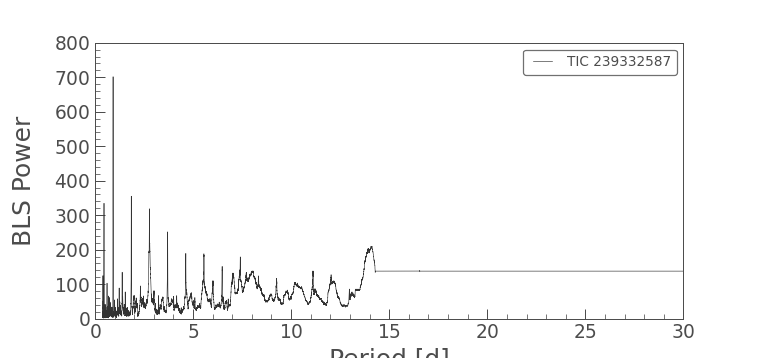

Period at max power = 0.9262932629326294 d
BLS max power = 701.4606410996853


In [11]:
#Here we use the Box Least Square method with a periodogram to search for periodic signals and calculate the exoplanet's period
import numpy as np
import matplotlib.pyplot as plt
period = np.linspace(0.4,30, 100000) # (start,end,steps). You can change the start and end timeframe.
bls = masked_lc.to_periodogram(method='bls', period=period);
bls.plot();
plt.ylabel('BLS Power', fontsize=20, labelpad=15)
plt.xlabel('Period [d]', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#Limits on x and y axis are given manually. You may need to change them depedning on the timeframe given.
plt.xlim(0,30) 
plt.ylim([0,800])

print('Period at max power =',bls.period_at_max_power)
print('BLS max power =', bls.max_power)

<IPython.core.display.Javascript object>


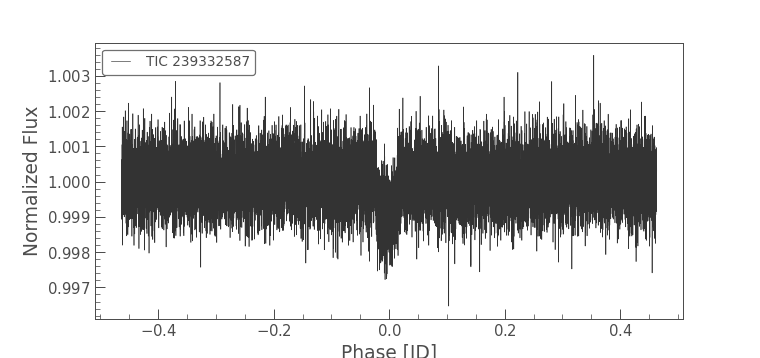

<IPython.core.display.Javascript object>


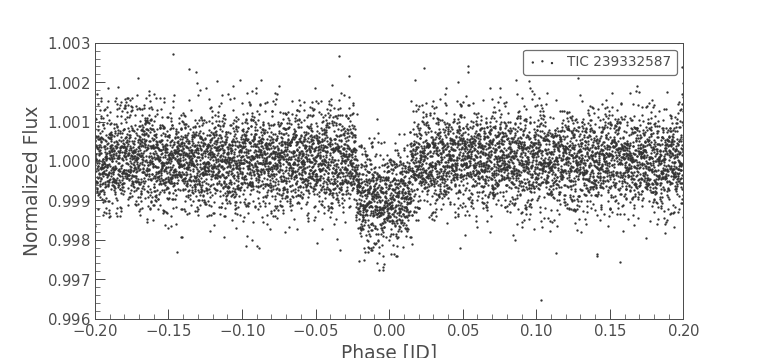

(0.996, 1.003)

In [12]:
#Here we will fold the lightcurve based on the period and the epoch time we found earlier.
#After folding your light curve you should see a signal (transit) on phase 0.
folded_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)
folded_lc.plot();
folded_lc.scatter(s=3)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.2,0.2)
plt.ylim([0.996,1.003])

<IPython.core.display.Javascript object>


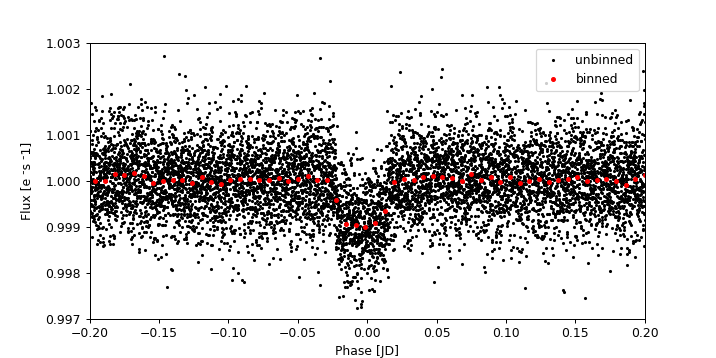

(0.997, 1.003)

In [13]:
period  = bls.period_at_max_power
t0 = bls.transit_time_at_max_power 

folded2_lc = masked_lc.fold(bls.period_at_max_power, epoch_time=bls.transit_time_at_max_power)

#Bin the folded lightcurve. Here we bin at 10 minutes.
folded2_lc_binned = folded_lc.bin(10/24/60)

fig, ax = plt.subplots(figsize = (8,4))

folded2_lc.plot(ax = ax, marker = '.', linewidth = 0, color = 'black', alpha = 1, markersize = 3)
folded2_lc_binned.plot(ax = ax, marker = 'o', linewidth = 0, color = 'red', alpha = 1, markersize = 3)
plt.legend(labels= ['unbinned', 'binned'], fontsize=10)
plt.ylabel('Flux [e ־s ־1]', fontsize=10, labelpad=10)
plt.xlabel('Phase [JD]', fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
#Limits on x and y axis are given manually. You may need to change them.
plt.xlim(-0.2,0.2)
plt.ylim([0.997,1.003])

In [14]:
min = np.nanmin(folded2_lc_binned.flux) #Minimum flux of the binned lightcurve
print('Minimum flux = ', min)
median = np.nanmedian(folded2_lc_binned.flux) #Median flux of the binned lightcurve. The median flux should be equal to 1.
print('median flux =', median)
Tdepth = median - min
print('Tdepth = ', Tdepth)
print('Tdepth in ppm = ', Tdepth * (10**6), 'ppm')
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio) #Exoplanet's radius and Star's radius ratio.

Minimum flux =  0.9989983439445496
median flux = 1.0000263452529907
Tdepth =  0.0010280013084411621
Tdepth in ppm =  1028.001308441162 ppm
Rp/Rs ratio =  0.03206245948833561


In [15]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power

In [16]:
planet_b_dur
print('Transit duration in hours=', planet_b_dur*24, 'hours')

Transit duration in hours= 1.2000000000000002 d hours


In [17]:
#Transit depth from bls model
planet_b_depth = bls.depth_at_max_power
print('depth = ', planet_b_depth)
print('depth in ppm =', planet_b_depth * (10**6), 'ppm')

depth =  0.0007194721953854774
depth in ppm = 719.4721953854774 ppm


In [18]:
print(bls.period_at_max_power)
print(bls.transit_time_at_max_power)
print(bls.duration_at_max_power)

0.9262932629326294 d
2420.5671715453595
0.05 d


# Exoplanet properties calculations
Search the target's TIC ID at https://exofop.ipac.caltech.edu/tess/ to get the star's properties needed for the calculations below.

In [19]:
P = 0.9262932629326294 * 24 * 60 * 60 #planet's period
G = 6.674* 10 ** -11 #gravitational constant
Msun = 1.98847 * 10**30 #Sun mass
M = 0.419577 * Msun #Star's mass
pi = math.pi
a = ((P**2)/((4*pi**2)/(G*M)))**(1/3) #Orbital radius or semi-major axis
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')

Orbital Radius
a = 2082702440.6480155 m
a = 2082702.4406480156 km
a = 0.013922005659623995 AU
The planetary mass was neglected


In [20]:
L = 0.026543  #Star's luminosity
ri= (L/1.1)**(1/2)
ro= (L/0.53)**(1/2)
print('Habitable Zone')
print('The inner boundary of the habitable zone ri =', ri, 'AU')
print('The outer boundary of the habitable zone ro =', ro, 'AU')

Habitable Zone
The inner boundary of the habitable zone ri = 0.15533834040570924 AU
The outer boundary of the habitable zone ro = 0.22378814105191477 AU


In [21]:
Rs = 0.425169 #Star's radius
Transit_depth = Tdepth
Rsun  = 696340 #Sun radius
Rearth = 6371 #Earth radius
Rp = (Rs * Transit_depth ** (1/2)) * Rsun #Exoplanet's radius derived from binning
print('Planet Radius from binning')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
aRs = (a/1000)/(Rs*Rsun)
print('Orbital Period and Star Radius ratio')
print('a/Rs =', aRs)
print('-------------------------')
Rpbls = (Rs * planet_b_depth ** (1/2)) * Rsun #Exoplanet's radius derived from bls model
print('Planet Radius from bls model')
print('Rp =', Rpbls, 'km')
print('Rp=',Rpbls/Rearth, 'Rearth')
aRsbls = (a/1000)/(Rs*Rsun)
print('Orbital Period and Star Radius ratio from bls model')
print('a/Rs =', aRsbls)

Planet Radius from binning
Rp = 9492.481699089516 km
Rp= 1.4899516087097027 Rearth
Orbital Period and Star Radius ratio
a/Rs = 7.034679101455594
-------------------------
Planet Radius from bls model
Rp = 7941.269637093836 km
Rp= 1.2464714545744524 Rearth
Orbital Period and Star Radius ratio from bls model
a/Rs = 7.034679101455594


In [22]:
P = 0.9262932629326294 * 24 * 60 * 60
pi = math.pi
a = a #semi-major axis in meters
v = (2*pi*a/P)
print('Planet Velocity')
print('v =',v , 'm/s')

Planet Velocity
v = 163510.19876409558 m/s


*** Summing up all calculated properties ***

In [23]:
print('Period = ',bls.period_at_max_power)
print('Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf = ', bls.duration_at_max_power*24,'hours')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Transit depth = ', Tdepth)
print('Transit depth in ppm = ', Tdepth * (10**6), 'ppm')
print('Transit Depth from bls model in ppm =', planet_b_depth * (10**6), 'ppm')
ratiobls = np.sqrt(planet_b_depth)
print('Rp/Rs ratio from bls model= ', ratiobls)
ratio = np.sqrt(Tdepth)
print('Rp/Rs ratio = ', ratio)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Radius')
print('Rp =', Rp, 'km')
print('Rp=',Rp/Rearth, 'Rearth')
print('Planet Radius from bls model')
print('Rp =', Rpbls, 'km')
print('Rp=',Rpbls/Rearth, 'Rearth')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Radius')
print('a =',a , 'm')
print('a =',a/1000 , 'km')
print('a =',a/1000 * 0.000000006684587, 'AU')
print('The planetary mass was neglected')
print('- - - - - - - - - - - - - - - - - - - - ')
print('Orbital Period and Star Radius ratio')
print('a/Rs', aRs)
print('- - - - - - - - - - - - - - - - - - - - ')
print('Planet Velocity')
print('v =',v , 'm/s')
print('- - - - - - - - - - - - - - - - - - - - ')


Period =  0.9262932629326294 d
Transit duration in hours planet disk fully superimposed to the stellar disk positions 2 - 3 Tf =  1.2000000000000002 d hours
- - - - - - - - - - - - - - - - - - - - 
Transit depth =  0.0010280013084411621
Transit depth in ppm =  1028.001308441162 ppm
Transit Depth from bls model in ppm = 719.4721953854774 ppm
Rp/Rs ratio from bls model=  0.02682297886860215
Rp/Rs ratio =  0.03206245948833561
- - - - - - - - - - - - - - - - - - - - 
Planet Radius
Rp = 9492.481699089516 km
Rp= 1.4899516087097027 Rearth
Planet Radius from bls model
Rp = 7941.269637093836 km
Rp= 1.2464714545744524 Rearth
- - - - - - - - - - - - - - - - - - - - 
Orbital Radius
a = 2082702440.6480155 m
a = 2082702.4406480156 km
a = 0.013922005659623995 AU
The planetary mass was neglected
- - - - - - - - - - - - - - - - - - - - 
Orbital Period and Star Radius ratio
a/Rs 7.034679101455594
- - - - - - - - - - - - - - - - - - - - 
Planet Velocity
v = 163510.19876409558 m/s
- - - - - - - - - - - - 

In [24]:
import cmath
print('Calculations from binning')
#FROM BINNING
#Calculation of total transit duration Tt
Tt = ((((4 * period **(2) * Tdepth ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (planet_b_dur ** (2))) ** (1/2)
print('Total transit duration T14 Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b for eccentricity e=0
#b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
b = abs(( ((1-cmath.sqrt(Tdepth))**(2)-(planet_b_dur/Tt)**(2)) * (1+cmath.sqrt(Tdepth))**(2)  ) / cmath.sqrt(1 - (planet_b_dur/Tt)**(2) ))
print('Impart parameter b =', b)
#Calculation of inclination
i = cmath.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i =', 90-i, 'deg')

Calculations from binning
Total transit duration T14 Tt = 0.052204427390979934 d
Tt in hours = 1.2529062573835184 d hours
Impart parameter b = 0.07251168634973218
Inclination i = (88.43951160188557+0j) deg


In [25]:
import cmath
print('Calculations from bls model')
#FROM BLS MODEL
#Calculation of total transit duration Tt
Tt = ((((4 * period **(2) * planet_b_depth ** (1/2))/(math.pi ** 2)) * (((Rs*Rsun)/(a/1000))**(2))) + (planet_b_dur ** (2))) ** (1/2)
print('Total transit duration T14 Tt =', Tt)
print('Tt in hours =', Tt * 24, 'hours')
#Calculation of the impact parameter b for eccentricity e=0
#b = (( ((1-(Tdepth **(1/2)))**(2)-(planet_b_dur/Tt)**(2))* (1+(Tdepth **(1/2)))**(2)  ) / (1 - (planet_b_dur/Tt)**(2) ) ) ** (1/2)
b = abs(( ((1-cmath.sqrt(planet_b_depth))**(2)-(planet_b_dur/Tt)**(2)) * (1+cmath.sqrt(planet_b_depth))**(2)  ) / cmath.sqrt(1 - (planet_b_dur/Tt)**(2) ))
print('Impart parameter b =', b)
#Calculation of inclination
i = cmath.acos(b*(Rs*Rsun)/(a/1000))
print('Inclination i =', 90-i, 'deg')

Calculations from bls model
Total transit duration T14 Tt = 0.05185059804233718 d
Tt in hours = 1.2444143530160923 d hours
Impart parameter b = 0.06841807181111301
Inclination i = (88.43892965352356+0j) deg


In [26]:
lk.show_citation_instructions()